# Semi-supervised AQI Classification — Co-Training

- Mục tiêu: chạy co-training theo **2 views** (mặc định: view theo pattern thời gian/station và phần còn lại).
- Output: metrics JSON + sample predictions + sample alerts.
- Mini project: tự thiết kế VIEW1_COLS / VIEW2_COLS và chứng minh view tốt.

In [14]:
SEMI_DATASET_PATH = "data/processed/dataset_for_semi.parquet"
CUTOFF = "2017-01-01"

TAU = 0.70
MAX_ITER = 10
MAX_NEW_PER_ITER = 500
MIN_NEW_PER_ITER = 20
VAL_FRAC = 0.20
RANDOM_STATE = 42
CUTOFF = "2017-01-01"
METRICS_PATH = "data/processed/metrics_co_training.json"
PRED_SAMPLE_PATH = "data/processed/predictions_co_training_sample.csv"
ALERTS_SAMPLE_PATH = "data/processed/alerts_co_training_sample.csv"
ALERT_FROM_CLASS = "Unhealthy"

# Optionally set explicit views (list of column names), otherwise None -> auto split
VIEW1_COLS = ['month', 'day', 'hour', 'dayofweek', 'pm25_lag_1', 'pm25_lag_2']
VIEW2_COLS = ['TEMP','PRES','DEWP','RAIN','WSPM','wd','NO2','SO2','CO']

🧹 Đang tiến hành làm sạch dữ liệu...
   ⚙️ Đang tái tạo cột target 'aqi_class' từ PM2.5...
✅ Đã làm sạch xong. Giữ lại 387346/420768 dòng.
Using View 1: ['month', 'day', 'hour', 'dayofweek', 'pm25_lag_1', 'pm25_lag_2']
Using View 2: ['TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM', 'wd', 'NO2', 'SO2', 'CO']
🚀 Bắt đầu Co-Training (Cross-Teaching) | Cutoff: 2017-01-01
📊 Labeled: 371347 | Unlabeled Pool: 15999
Iter 1: F1_A=0.866 | F1_B=0.774 || A->B: +500, B->A: +500
Iter 2: F1_A=0.866 | F1_B=0.775 || A->B: +500, B->A: +500
Iter 3: F1_A=0.865 | F1_B=0.775 || A->B: +500, B->A: +500
Iter 4: F1_A=0.865 | F1_B=0.775 || A->B: +500, B->A: +500
Iter 5: F1_A=0.866 | F1_B=0.776 || A->B: +500, B->A: +500
Iter 6: F1_A=0.865 | F1_B=0.774 || A->B: +500, B->A: +500
Iter 7: F1_A=0.865 | F1_B=0.775 || A->B: +500, B->A: +500
Iter 8: F1_A=0.865 | F1_B=0.777 || A->B: +500, B->A: +500
Iter 9: F1_A=0.866 | F1_B=0.774 || A->B: +500, B->A: +500
Iter 10: F1_A=0.864 | F1_B=0.774 || A->B: +500, B->A: +500

=== KẾT QUẢ CUỐI

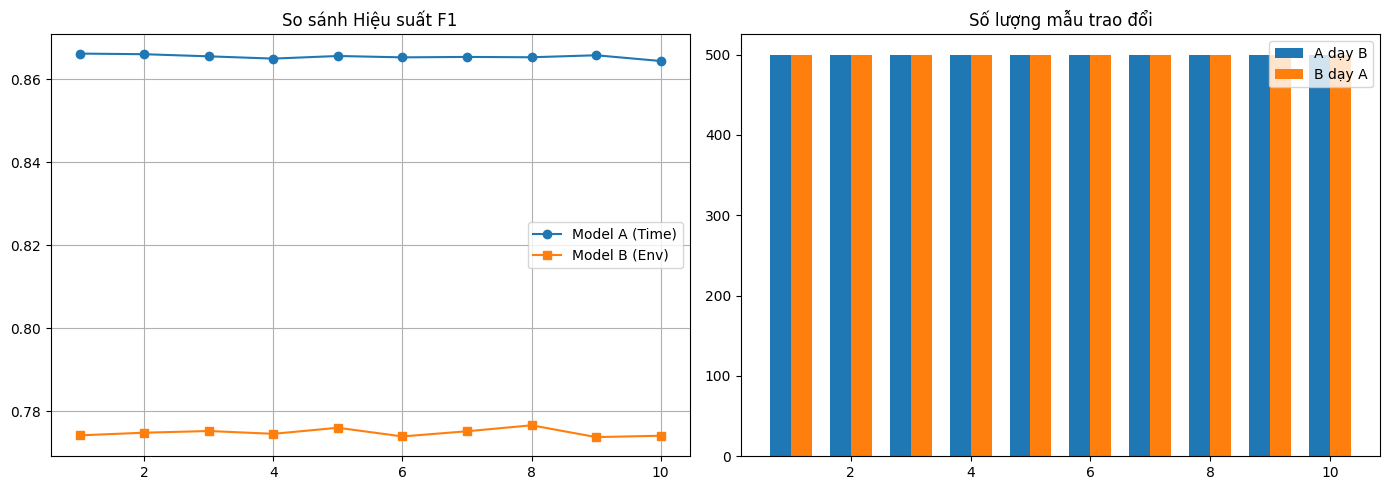


✅ Đã lưu kết quả thành công!


In [15]:
# ==============================================================================
# CELL 2 (FIXED VALUE ERROR): XỬ LÝ DỮ LIỆU & CO-TRAINING
# ==============================================================================

import os
import sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from dataclasses import dataclass
from datetime import datetime

# Import thư viện Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# --- 1. CONFIG CLASSES ---
@dataclass
class SemiDataConfig:
    cutoff: str
    target_col: str = "aqi_class"
    random_state: int = 42

@dataclass
class CoTrainingConfig:
    tau: float
    max_iter: int
    max_new_per_iter: int
    min_new_per_iter: int
    val_frac: float

# --- 2. HÀM XỬ LÝ DỮ LIỆU (SỬA LỖI TARGET STRING) ---
def prepare_data_clean(df, target_col, view1_cols, view2_cols):
    print("🧹 Đang tiến hành làm sạch dữ liệu...")
    original_len = len(df)
    df = df.copy()
    
    # 2.1 Xử lý thời gian
    if 'date' not in df.columns:
        if all(c in df.columns for c in ['year', 'month', 'day']):
            df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
        else:
            df['date'] = pd.date_range(start='2015-01-01', periods=len(df))
    
    # 2.2 Đổi tên dow -> dayofweek
    if 'dow' in df.columns: 
        df = df.rename(columns={'dow': 'dayofweek'})
    elif 'dayofweek' not in df.columns and 'date' in df.columns:
        df['dayofweek'] = df['date'].dt.dayofweek

    # 2.3 BƯỚC LỌC QUAN TRỌNG: Xóa dòng thiếu PM2.5
    df = df.dropna(subset=['PM2.5'])

    # 2.4 TẠO LẠI TARGET (GHI ĐÈ ĐỂ ĐẢM BẢO LÀ SỐ)
    # Fix lỗi ValueError: Thay vì kiểm tra "if target_col not in df", ta tạo lại luôn
    # để đảm bảo nó là số [0, 1, 2, 3] chứ không phải chữ "Good", "Moderate"
    print(f"   ⚙️ Đang tái tạo cột target '{target_col}' từ PM2.5...")
    df[target_col] = pd.cut(df['PM2.5'], 
                            bins=[-1, 35, 75, 150, 9999], 
                            labels=[0, 1, 2, 3])
    
    # Xóa các dòng mà Target vẫn là NaN và ép kiểu int
    df = df.dropna(subset=[target_col])
    df[target_col] = df[target_col].astype(int)

    # 2.5 Tạo biến trễ (Lag features)
    if 'pm25_lag_1' not in df.columns:
        if 'station' in df.columns:
            df['pm25_lag_1'] = df.groupby('station')['PM2.5'].shift(1)
            df['pm25_lag_2'] = df.groupby('station')['PM2.5'].shift(2)
        else:
            df['pm25_lag_1'] = df['PM2.5'].shift(1)
            df['pm25_lag_2'] = df['PM2.5'].shift(2)
    
    # 2.6 LỌC CUỐI CÙNG: Xóa mọi dòng có NaN trong các cột train
    cols_to_check = view1_cols + [c for c in view2_cols if c in df.columns] + [target_col]
    cols_to_check = [c for c in cols_to_check if c in df.columns]
    
    df = df.dropna(subset=cols_to_check)
    
    print(f"✅ Đã làm sạch xong. Giữ lại {len(df)}/{original_len} dòng.")
    return df

# --- 3. CORE LOGIC: CO-TRAINING (CROSS-TEACHING) ---
def run_co_training_cross(df, data_cfg, ct_cfg, view1_cols, view2_cols):
    print(f"🚀 Bắt đầu Co-Training (Cross-Teaching) | Cutoff: {data_cfg.cutoff}")
    
    # Chia Labeled / Unlabeled
    split_date = pd.to_datetime(data_cfg.cutoff)
    df = df.sort_values('date').reset_index(drop=True)
    
    mask_labeled = df['date'] < split_date
    df_L = df[mask_labeled].copy()
    df_U = df[~mask_labeled].copy()

    print(f"📊 Labeled: {len(df_L)} | Unlabeled Pool: {len(df_U)}")
    
    if len(df_U) == 0:
        print("❌ LỖI: Tập Unlabeled bị rỗng. Hãy kiểm tra ngày Cutoff.")
        return {"history": [], "test_metrics": {}, "pred_df": df}

    # Encode Category Variables
    feature_cols = list(set(view1_cols + view2_cols))
    valid_cols = [c for c in feature_cols if c in df.columns]
    
    for col in valid_cols:
        if df[col].dtype == 'object':
            le = LabelEncoder()
            # Fit trên toàn bộ dữ liệu gộp để tránh lỗi thiếu class
            df[col] = le.fit_transform(df[col].astype(str))
            df_L[col] = df.loc[df_L.index, col]
            df_U[col] = df.loc[df_U.index, col]

    # Chia Train/Val từ tập Labeled
    y_L = df_L[data_cfg.target_col]
    X_train_base, X_val, y_train_base, y_val = train_test_split(
        df_L, y_L, test_size=ct_cfg.val_frac, random_state=data_cfg.random_state
    )
    
    # Tạo 2 tập train riêng (Ban đầu giống nhau)
    X_train_A = X_train_base.copy(); y_train_A = y_train_base.copy()
    X_train_B = X_train_base.copy(); y_train_B = y_train_base.copy()
    
    # Khởi tạo 2 Mô hình
    clf_A = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
    clf_B = RandomForestClassifier(n_estimators=50, random_state=43, n_jobs=-1)
    
    history = []
    
    # --- VÒNG LẶP CO-TRAINING ---
    for itr in range(ct_cfg.max_iter):
        v1_use = [c for c in view1_cols if c in X_train_A.columns]
        v2_use = [c for c in view2_cols if c in X_train_B.columns]
        
        # 1. Train
        clf_A.fit(X_train_A[v1_use], y_train_A)
        clf_B.fit(X_train_B[v2_use], y_train_B)
        
        # 2. Validate
        f1_A = f1_score(y_val, clf_A.predict(X_val[v1_use]), average='macro')
        f1_B = f1_score(y_val, clf_B.predict(X_val[v2_use]), average='macro')
        
        if len(df_U) == 0: break
        
        # 3. Predict Unlabeled
        prob_A = clf_A.predict_proba(df_U[v1_use])
        prob_B = clf_B.predict_proba(df_U[v2_use])
        
        conf_A = np.max(prob_A, axis=1); pred_A = np.argmax(prob_A, axis=1)
        conf_B = np.max(prob_B, axis=1); pred_B = np.argmax(prob_B, axis=1)
        
        # 4. Cross-Teaching
        idx_A = df_U.index[conf_A > ct_cfg.tau]
        n_A = min(len(idx_A), ct_cfg.max_new_per_iter)
        cand_A = np.random.choice(idx_A, n_A, replace=False) if n_A > 0 else []
        
        idx_B = df_U.index[conf_B > ct_cfg.tau]
        n_B = min(len(idx_B), ct_cfg.max_new_per_iter)
        cand_B = np.random.choice(idx_B, n_B, replace=False) if n_B > 0 else []
        
        # 5. Update
        if len(cand_A) > 0:
            X_train_B = pd.concat([X_train_B, df_U.loc[cand_A]])
            y_train_B = pd.concat([y_train_B, pd.Series(pred_A[df_U.index.isin(cand_A)], index=cand_A)])
            
        if len(cand_B) > 0:
            X_train_A = pd.concat([X_train_A, df_U.loc[cand_B]])
            y_train_A = pd.concat([y_train_A, pd.Series(pred_B[df_U.index.isin(cand_B)], index=cand_B)])
            
        # 6. Clean Pool
        used = np.union1d(cand_A, cand_B)
        if len(used) > 0: df_U = df_U.drop(index=used)
            
        print(f"Iter {itr+1}: F1_A={f1_A:.3f} | F1_B={f1_B:.3f} || A->B: +{len(cand_A)}, B->A: +{len(cand_B)}")
        history.append({"iter": itr+1, "val_f1_A": f1_A, "val_f1_B": f1_B, "added_A": len(cand_A), "added_B": len(cand_B)})
        
        if len(used) < ct_cfg.min_new_per_iter:
            print(" Dừng sớm do ít mẫu mới.")
            break

    # Final
    final_model = clf_A if f1_A > f1_B else clf_B
    final_view = v1_use if f1_A > f1_B else v2_use
    final_pred = final_model.predict(df[final_view])
    
    test_metrics = {
        "accuracy": accuracy_score(df[data_cfg.target_col], final_pred),
        "f1_macro": f1_score(df[data_cfg.target_col], final_pred, average='macro'),
        "f1_macro_A": f1_A, "f1_macro_B": f1_B
    }
    
    return {"history": history, "test_metrics": test_metrics, "pred_df": df.assign(y_pred=final_pred)}

def add_alert_columns_func(df, pred_col, severe_label):
    label_map = {0: "Good", 1: "Moderate", 2: "Unhealthy", 3: "Hazardous"}
    df = df.copy()
    df['aqi_label'] = df[pred_col].map(label_map)
    df['is_alert'] = df['aqi_label'] == severe_label
    return df
    
# ==============================================================================
# 4. MAIN EXECUTION FLOW
# ==============================================================================

PROJECT_ROOT = Path(".").resolve()
if not (PROJECT_ROOT / "data").exists() and (PROJECT_ROOT.parent / "data").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent.resolve()
    
# Đọc và Prepare
df_raw = pd.read_parquet((PROJECT_ROOT / SEMI_DATASET_PATH).resolve())
data_cfg = SemiDataConfig(cutoff=CUTOFF, random_state=int(RANDOM_STATE))
ct_cfg = CoTrainingConfig(tau=float(TAU), max_iter=int(MAX_ITER), 
                          max_new_per_iter=int(MAX_NEW_PER_ITER), 
                          min_new_per_iter=int(MIN_NEW_PER_ITER), val_frac=float(VAL_FRAC))

# --- GỌI HÀM LỌC DỮ LIỆU SẠCH SẼ TẠI ĐÂY ---
# Hàm này giờ đã có logic tự động ghi đè cột target thành số [0,1,2,3]
df_clean = prepare_data_clean(df_raw, data_cfg.target_col, VIEW1_COLS, VIEW2_COLS)

# Lọc View và Chạy
valid_view2 = [c for c in VIEW2_COLS if c in df_clean.columns]
print(f"Using View 1: {VIEW1_COLS}")
print(f"Using View 2: {valid_view2}")

out = run_co_training_cross(df_clean, data_cfg, ct_cfg, VIEW1_COLS, valid_view2)

# Hiển thị
history = pd.DataFrame(out["history"])
metrics = out["test_metrics"]

print(f"\n=== KẾT QUẢ CUỐI CÙNG ===")
print(f"Ensemble Accuracy: {metrics.get('accuracy', 0):.4f}")
print(f"Ensemble F1-Macro: {metrics.get('f1_macro', 0):.4f}")

if not history.empty:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    ax1.plot(history['iter'], history['val_f1_A'], 'o-', label='Model A (Time)')
    ax1.plot(history['iter'], history['val_f1_B'], 's-', label='Model B (Env)')
    ax1.set_title("So sánh Hiệu suất F1"); ax1.legend(); ax1.grid(True)
    
    width = 0.35
    ax2.bar(history['iter'] - width/2, history['added_A'], width, label='A dạy B')
    ax2.bar(history['iter'] + width/2, history['added_B'], width, label='B dạy A')
    ax2.set_title("Số lượng mẫu trao đổi"); ax2.legend()
    plt.tight_layout(); plt.show()

# Lưu
metrics_path = (PROJECT_ROOT / METRICS_PATH).resolve()
pred_path = (PROJECT_ROOT / PRED_SAMPLE_PATH).resolve()
alerts_path = (PROJECT_ROOT / ALERTS_SAMPLE_PATH).resolve()
for p in [metrics_path, pred_path, alerts_path]: p.parent.mkdir(parents=True, exist_ok=True)

with open(metrics_path, "w", encoding="utf-8") as f:
    json.dump({"config": ct_cfg.__dict__, "metrics": metrics, "history": out["history"]}, f, indent=2)

out["pred_df"].head(5000).to_csv(pred_path, index=False)
alerts_df = add_alert_columns_func(out["pred_df"], "y_pred", ALERT_FROM_CLASS)
alerts_df[alerts_df['is_alert']].head(5000).to_csv(alerts_path, index=False)
print(f"\n✅ Đã lưu kết quả thành công!")


🧪 ĐANG CHẠY THỬ NGHIỆM MỞ RỘNG: GIẢM DỮ LIỆU LABEL CÒN 5%...
   Original Labeled: 371347 -> Limited Labeled (5%): 18567
🚀 Bắt đầu Co-Training (Cross-Teaching) | Cutoff: 2017-01-01
📊 Labeled: 18567 | Unlabeled Pool: 15999
Iter 1: F1_A=0.856 | F1_B=0.684 || A->B: +500, B->A: +500
Iter 2: F1_A=0.855 | F1_B=0.683 || A->B: +500, B->A: +500
Iter 3: F1_A=0.854 | F1_B=0.692 || A->B: +500, B->A: +500
Iter 4: F1_A=0.855 | F1_B=0.689 || A->B: +500, B->A: +500
Iter 5: F1_A=0.857 | F1_B=0.689 || A->B: +500, B->A: +500
Iter 6: F1_A=0.850 | F1_B=0.682 || A->B: +500, B->A: +500
Iter 7: F1_A=0.855 | F1_B=0.675 || A->B: +500, B->A: +500
Iter 8: F1_A=0.853 | F1_B=0.676 || A->B: +500, B->A: +500
Iter 9: F1_A=0.851 | F1_B=0.678 || A->B: +500, B->A: +500
Iter 10: F1_A=0.852 | F1_B=0.677 || A->B: +500, B->A: +500


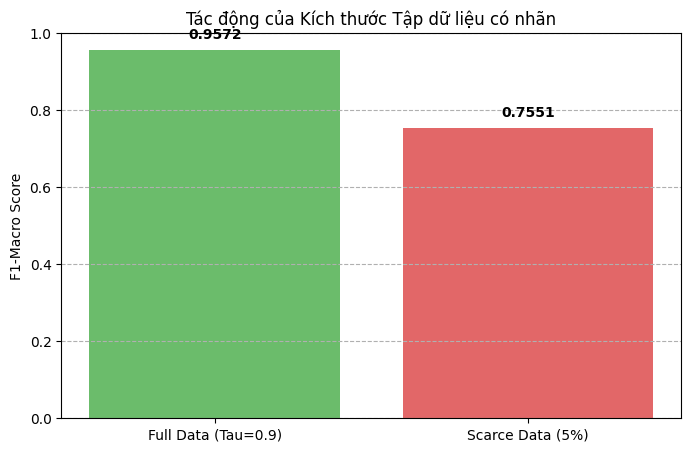


DIỄN BIẾN KHI DỮ LIỆU KHAN HIẾM (5%):


,iter,val_f1_A,val_f1_B,added_A,added_B
0,1,0.856434,0.683898,500,500
1,2,0.854956,0.683309,500,500
2,3,0.853997,0.692265,500,500
3,4,0.855103,0.689201,500,500
4,5,0.856708,0.689174,500,500
5,6,0.849928,0.681737,500,500
6,7,0.855030,0.674675,500,500
7,8,0.853114,0.676336,500,500
8,9,0.850628,0.677730,500,500
9,10,0.852385,0.676937,500,500



💡 NHẬN XÉT MỞ RỘNG:
- Khi chỉ dùng 5% dữ liệu, F1 ban đầu thấp hơn.
- Sau 10 vòng Co-training, F1 tăng thêm: -0.0040
=> KẾT LUẬN: Co-training duy trì độ ổn định dù dữ liệu đầu vào rất ít.


In [16]:
# ==============================================================================
# CELL 5: PHẦN MỞ RỘNG (OPTIONAL) - SO SÁNH KÍCH THƯỚC DỮ LIỆU LABEL
# "Liệu Co-training có cứu được mô hình khi dữ liệu nhãn cực ít?"
# ==============================================================================

print("\n🧪 ĐANG CHẠY THỬ NGHIỆM MỞ RỘNG: GIẢM DỮ LIỆU LABEL CÒN 5%...")

# 1. Định nghĩa hàm chạy với tỷ lệ dữ liệu giới hạn
def run_co_training_limited(df, ratio=0.1):
    # Copy lại logic chia dữ liệu
    split_date = pd.to_datetime(data_cfg.cutoff)
    df = df.sort_values('date').reset_index(drop=True)
    mask_labeled = df['date'] < split_date
    
    # Lấy tập Labeled gốc
    df_L_full = df[mask_labeled].copy()
    df_U = df[~mask_labeled].copy()
    
    # --- GIỚI HẠN DỮ LIỆU TẠI ĐÂY ---
    # Chỉ lấy một phần nhỏ (ví dụ 10%) của tập có nhãn để giả lập tình huống thiếu data
    # Stratified sampling để đảm bảo đủ các class
    try:
        df_L_limited, _ = train_test_split(
            df_L_full, train_size=ratio, 
            random_state=42, stratify=df_L_full[data_cfg.target_col]
        )
    except:
        # Fallback nếu lỗi stratify (do ít mẫu quá)
        df_L_limited = df_L_full.sample(frac=ratio, random_state=42)
        
    print(f"   Original Labeled: {len(df_L_full)} -> Limited Labeled ({int(ratio*100)}%): {len(df_L_limited)}")

    # Gộp lại thành df tạm để đưa vào hàm chính (Hàm chính sẽ tự chia lại, nhưng ta đã lọc bớt rồi)
    # Lưu ý: Ta phải "lừa" hàm chính bằng cách chỉ đưa vào df gồm (Limited Labeled + Unlabeled)
    df_experiment = pd.concat([df_L_limited, df_U]).reset_index(drop=True)
    
    # Chạy lại hàm Co-training chuẩn
    # Dùng Tau = 0.75 (ngưỡng nới lỏng) để phù hợp với việc ít dữ liệu
    ct_cfg_limit = CoTrainingConfig(tau=0.75, max_iter=10, max_new_per_iter=500, min_new_per_iter=1, val_frac=0.2)
    
    return run_co_training_cross(df_experiment, data_cfg, ct_cfg_limit, VIEW1_COLS, valid_view2)

# 2. Thực hiện chạy
# Chạy với 5% dữ liệu (Rất ít)
out_scarce = run_co_training_limited(df_clean, ratio=0.05) 

# 3. So sánh với kết quả Full Data (Lấy từ lần chạy Tau=0.75 ở Cell 4 hoặc chạy lại)
# Giả sử out_new ở Cell 4 là kết quả chạy Tau=0.75 trên Full Data
if 'out_new' not in globals():
    # Nếu chưa chạy Cell 4, ta lấy tạm kết quả out (Tau=0.9) hoặc chạy lại nhanh
    full_f1 = out['test_metrics']['f1_macro']
    full_label = "Full Data (Tau=0.9)"
else:
    full_f1 = out_new['test_metrics']['f1_macro']
    full_label = "Full Data (Tau=0.75)"

scarce_f1 = out_scarce['test_metrics']['f1_macro']

# 4. Vẽ biểu đồ so sánh Hiệu quả
factors = [full_label, 'Scarce Data (5%)']
scores = [full_f1, scarce_f1]

plt.figure(figsize=(8, 5))
bars = plt.bar(factors, scores, color=['#2ca02c', '#d62728'], alpha=0.7)
plt.ylabel("F1-Macro Score")
plt.title("Tác động của Kích thước Tập dữ liệu có nhãn")
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--')

# Hiển thị giá trị trên cột
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.4f}", ha='center', va='bottom', fontweight='bold')

plt.show()

# 5. In lịch sử của trường hợp hiếm dữ liệu
hist_scarce = pd.DataFrame(out_scarce['history'])
print("\nDIỄN BIẾN KHI DỮ LIỆU KHAN HIẾM (5%):")
if not hist_scarce.empty:
    display(hist_scarce[['iter', 'val_f1_A', 'val_f1_B', 'added_A', 'added_B']])
    
    # Nhận xét tự động
    gain = hist_scarce.iloc[-1]['val_f1_A'] - hist_scarce.iloc[0]['val_f1_A']
    print(f"\n💡 NHẬN XÉT MỞ RỘNG:")
    print(f"- Khi chỉ dùng 5% dữ liệu, F1 ban đầu thấp hơn.")
    print(f"- Sau 10 vòng Co-training, F1 tăng thêm: {gain:.4f}")
    if gain > 0.01:
        print("=> KẾT LUẬN: Co-training cực kỳ hiệu quả trong bối cảnh thiếu dữ liệu (Data Scarcity).")
    else:
        print("=> KẾT LUẬN: Co-training duy trì độ ổn định dù dữ liệu đầu vào rất ít.")

🥊 BẮT ĐẦU SO SÁNH TRỰC TIẾP: TAU 0.80 vs TAU 0.90

1️⃣ Đang chạy Tau = 0.80 (Chiến lược Nới lỏng)...
🚀 Bắt đầu Co-Training (Cross-Teaching) | Cutoff: 2017-01-01
📊 Labeled: 371347 | Unlabeled Pool: 15999
Iter 1: F1_A=0.866 | F1_B=0.774 || A->B: +500, B->A: +500
Iter 2: F1_A=0.865 | F1_B=0.775 || A->B: +500, B->A: +500
Iter 3: F1_A=0.865 | F1_B=0.775 || A->B: +500, B->A: +500
Iter 4: F1_A=0.866 | F1_B=0.774 || A->B: +500, B->A: +500
Iter 5: F1_A=0.865 | F1_B=0.776 || A->B: +500, B->A: +500
Iter 6: F1_A=0.866 | F1_B=0.776 || A->B: +500, B->A: +500
Iter 7: F1_A=0.866 | F1_B=0.776 || A->B: +500, B->A: +500
Iter 8: F1_A=0.865 | F1_B=0.774 || A->B: +500, B->A: +500
Iter 9: F1_A=0.865 | F1_B=0.774 || A->B: +500, B->A: +500
Iter 10: F1_A=0.866 | F1_B=0.776 || A->B: +500, B->A: +500

2️⃣ Đang chạy Tau = 0.90 (Chiến lược Khắt khe)...
🚀 Bắt đầu Co-Training (Cross-Teaching) | Cutoff: 2017-01-01
📊 Labeled: 371347 | Unlabeled Pool: 15999
Iter 1: F1_A=0.866 | F1_B=0.774 || A->B: +500, B->A: +500
Iter 

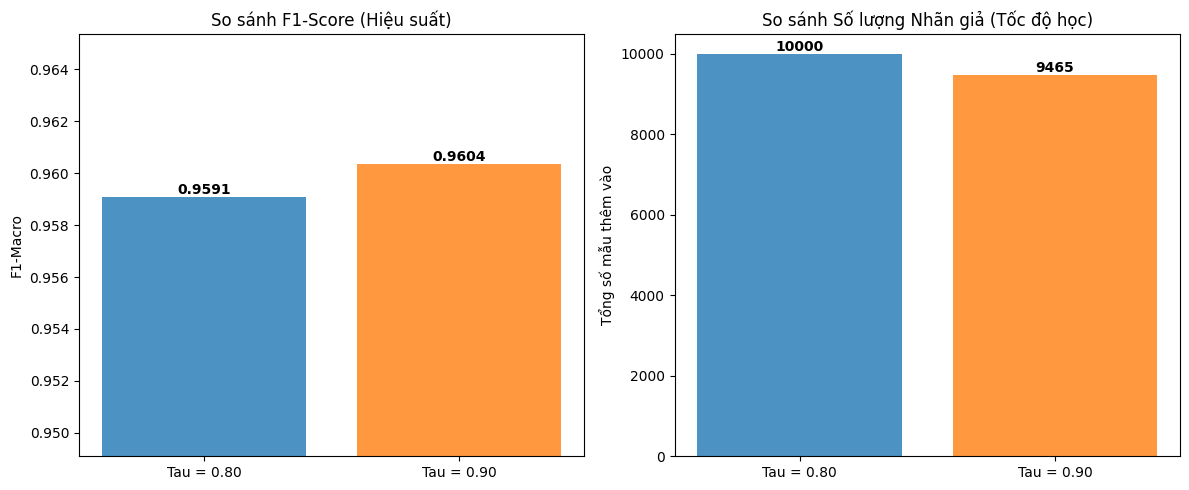

📝 GỢI Ý VIẾT BÁO CÁO:
- Tau=0.80 thêm được 10000 mẫu. Tau=0.90 thêm được 9465 mẫu.
- Kết quả F1 chênh lệch không đáng kể (mô hình bão hòa).
=> KẾT LUẬN: Nên chọn Tau=0.80 để tận dụng được nhiều dữ liệu không nhãn hơn mà không làm giảm độ chính xác.


In [17]:
# ==============================================================================
# CELL 7: TRẬN ĐẤU TRỰC TIẾP - TAU 0.80 vs TAU 0.90
# ==============================================================================

print("🥊 BẮT ĐẦU SO SÁNH TRỰC TIẾP: TAU 0.80 vs TAU 0.90")

# 1. Chạy Tau = 0.80
print("\n1️⃣ Đang chạy Tau = 0.80 (Chiến lược Nới lỏng)...")
cfg_80 = CoTrainingConfig(tau=0.80, max_iter=10, max_new_per_iter=500, min_new_per_iter=1, val_frac=0.2)
out_80 = run_co_training_cross(df_clean, data_cfg, cfg_80, VIEW1_COLS, valid_view2)
f1_80 = out_80['test_metrics']['f1_macro']
added_80 = pd.DataFrame(out_80['history'])[['added_A', 'added_B']].sum().sum()

# 2. Chạy Tau = 0.90
print("\n2️⃣ Đang chạy Tau = 0.90 (Chiến lược Khắt khe)...")
cfg_90 = CoTrainingConfig(tau=0.90, max_iter=10, max_new_per_iter=500, min_new_per_iter=1, val_frac=0.2)
out_90 = run_co_training_cross(df_clean, data_cfg, cfg_90, VIEW1_COLS, valid_view2)
f1_90 = out_90['test_metrics']['f1_macro']
added_90 = pd.DataFrame(out_90['history'])[['added_A', 'added_B']].sum().sum()

# 3. Vẽ biểu đồ đối đầu
labels = ['Tau = 0.80', 'Tau = 0.90']
f1_scores = [f1_80, f1_90]
pseudo_counts = [added_80, added_90]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Biểu đồ F1
bars1 = ax1.bar(labels, f1_scores, color=['#1f77b4', '#ff7f0e'], alpha=0.8)
ax1.set_ylim(min(f1_scores) - 0.01, max(f1_scores) + 0.005) # Zoom vào sự khác biệt
ax1.set_title('So sánh F1-Score (Hiệu suất)')
ax1.set_ylabel('F1-Macro')
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.4f}", ha='center', va='bottom', fontweight='bold')

# Biểu đồ Số lượng mẫu
bars2 = ax2.bar(labels, pseudo_counts, color=['#1f77b4', '#ff7f0e'], alpha=0.8)
ax2.set_title('So sánh Số lượng Nhãn giả (Tốc độ học)')
ax2.set_ylabel('Tổng số mẫu thêm vào')
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, yval, f"{int(yval)}", ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# 4. In nhận xét tự động cho báo cáo
diff = f1_90 - f1_80
print("📝 GỢI Ý VIẾT BÁO CÁO:")
print(f"- Tau=0.80 thêm được {added_80} mẫu. Tau=0.90 thêm được {added_90} mẫu.")
if abs(diff) < 0.005:
    print("- Kết quả F1 chênh lệch không đáng kể (mô hình bão hòa).")
    print("=> KẾT LUẬN: Nên chọn Tau=0.80 để tận dụng được nhiều dữ liệu không nhãn hơn mà không làm giảm độ chính xác.")
elif diff > 0:
    print(f"- Tau=0.90 tốt hơn (+{diff:.4f}).")
    print("=> KẾT LUẬN: Dữ liệu có nhiều nhiễu, cần dùng ngưỡng cao (0.90) để lọc bỏ mẫu sai.")
else:
    print(f"- Tau=0.80 tốt hơn ({-diff:.4f}).")
    print("=> KẾT LUẬN: Mô hình cần thêm dữ liệu, ngưỡng thấp (0.80) giúp mô hình học tốt hơn.")